# Dropout

In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as  F 

In [3]:
# Define a dropout instance and make some data

proba = .5
dropout = nn.Dropout(proba)

x = torch.ones(10)
y = dropout(x) 

print(y)
print(torch.mean(y))

tensor([2., 0., 2., 0., 2., 2., 2., 0., 0., 0.])
tensor(1.)


In [4]:
# Dropout is turned off during evaluation
dropout.eval()
y = dropout(x)
print(y)            
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [5]:
# when we want to turn dropout on, we can use the train() method
dropout.train()
y = dropout(x)
print(y)

tensor([2., 2., 0., 0., 0., 2., 2., 0., 0., 2.])


# Practical example

## Creating the data

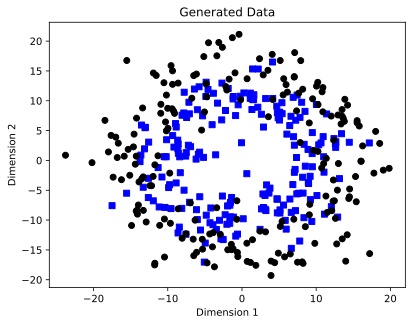

In [6]:
nPerClust = 200
th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# Generate data
a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)*3]

b = [r2*np.cos(th) + np.random.randn(nPerClust)*3,
     r2*np.sin(th) + np.random.randn(nPerClust)*3]   

# True labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
# concatenate the two sets of points into a matrix      
data_np = np.hstack((a,b)).T
# Convert to a tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

#show the data
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('Generated Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## Separate data into DataLoaders

In [7]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, create DataLoaders
batch_size = 16
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

## Create the model 

In [8]:
class TheModelClass(nn.Module):
    def __init__(self,dropout_rate):
        super().__init__()

        # Layers
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        # Params
 
        self.dr = dropout_rate


        
    def forward(self, x):  
        # pass the data through the input layer
        x = F.relu(self.input(x))

        # Dropout after the input layer
        x = F.dropout(x, p=self.dr,training=self.training)

        # pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # Dropout after the hidden layer
        x = F.dropout(x, p=self.dr,training=self.training)

        # pass the data through the output layer   
        x = self.output(x)
        return x


## Functions to create and train the model

In [12]:
def createNewModel(dropout_rate=0):

    # grab an instance of the model class 
    model = TheModelClass(dropout_rate)
     
    # loss function
    loss_function = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.002) 
    
    return model , loss_function, optimizer    

In [11]:
# train the model




def trainTheModel(model,loss_function,optimizer,train_loader=train_loader,test_loader=test_loader,num_epochs=1000):

    # initialize accuracies as empty lists
    trainAcc = []
    testAcc = []

    
    
    for epoch in range(num_epochs):
        model.train() # put model in training mode
        batchAcc = []
        for X,y in train_loader:
            
            # forward pass and loss computation
            y_pred = model(X)
            loss = loss_function(y_pred, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute accuracy just for this batch
            batchAcc.append(100*torch.mean(((y_pred > .5) == y).float()).item())  
        # end of batch loop
        # now that we trained through all the batches in the training set, let's compute the accuracy for this epoch by averaging the batch accuracies
        trainAcc.append(np.mean(batchAcc))
        print(f'Epoch {epoch} training accuracy {trainAcc[-1]}')

        # test accuracy
        model.eval() # turn off dropout
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        y_pred = model(X) # forward pass
        testAcc.append(100*torch.mean(((y_pred > .5) == y).float()).item()) # compute accuracy and append to list

    return trainAcc, testAcc    
            

# Test the model

In [47]:
dropout_rate = 0
model,loss_function,optimizer = createNewModel(dropout_rate)
# train the model
trainAcc, testAcc = trainTheModel(model,loss_function,optimizer)  

Epoch 0 training accuracy 59.375
Epoch 1 training accuracy 61.5625
Epoch 2 training accuracy 61.25
Epoch 3 training accuracy 62.5
Epoch 4 training accuracy 61.25
Epoch 5 training accuracy 64.0625
Epoch 6 training accuracy 60.625
Epoch 7 training accuracy 61.875
Epoch 8 training accuracy 61.25
Epoch 9 training accuracy 68.125
Epoch 10 training accuracy 65.3125
Epoch 11 training accuracy 60.9375
Epoch 12 training accuracy 68.4375
Epoch 13 training accuracy 69.375
Epoch 14 training accuracy 59.375
Epoch 15 training accuracy 64.0625
Epoch 16 training accuracy 63.4375
Epoch 17 training accuracy 66.5625
Epoch 18 training accuracy 65.3125
Epoch 19 training accuracy 66.25
Epoch 20 training accuracy 65.0
Epoch 21 training accuracy 63.75
Epoch 22 training accuracy 63.125
Epoch 23 training accuracy 67.5
Epoch 24 training accuracy 65.625
Epoch 25 training accuracy 65.9375
Epoch 26 training accuracy 66.875
Epoch 27 training accuracy 65.9375
Epoch 28 training accuracy 61.25
Epoch 29 training accurac

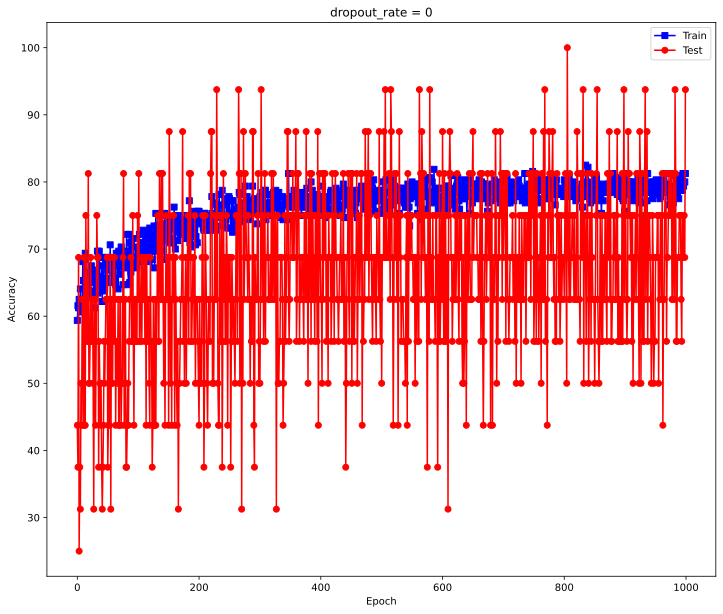

In [53]:
# plot the results
fig = plt.figure(figsize=(12,10))    

plt.plot(trainAcc,'bs-',label='Train Acc')
plt.plot(testAcc,'ro-',label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title(f'dropout_rate = {dropout_rate}')
plt.show()

**Note**
 - The graph is not realy interpretable and that happened because of the `batch size`

 - When the `batch size` is relatively small that limit the precision of the accuracy and the possible values

 - We should change the batch size but in this case we will only smooth the visualization

In [20]:
def smooth(x,k=15):
    return np.convolve(x,np.ones(k)/k,mode='same')

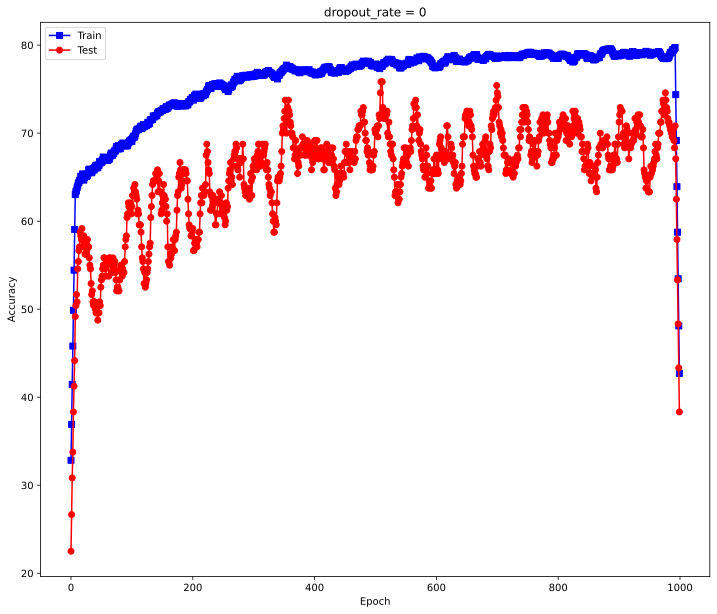

In [59]:
# plot the results
fig = plt.figure(figsize=(12,10))    

plt.plot(smooth(trainAcc),'bs-',label='Train Acc')
plt.plot(smooth(testAcc),'ro-',label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.title(f'dropout_rate = {dropout_rate}')
plt.show()

# Run the experiment

In [70]:
dropout_rate = np.arange(10)/10
results = np.zeros((len(dropout_rate),2))
for di in range(len(dropout_rate)):
    model,loss_function,optimizer = createNewModel(dropout_rate[di])
    trainAcc, testAcc = trainTheModel(model,loss_function,optimizer)  
    
    # store accuracies from the last 100 epochs
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,1] = np.mean(testAcc[-100:])

Epoch 0 training accuracy 51.875
Epoch 1 training accuracy 55.9375
Epoch 2 training accuracy 60.9375
Epoch 3 training accuracy 65.0
Epoch 4 training accuracy 60.3125
Epoch 5 training accuracy 61.875
Epoch 6 training accuracy 65.9375
Epoch 7 training accuracy 66.875
Epoch 8 training accuracy 62.5
Epoch 9 training accuracy 64.6875
Epoch 10 training accuracy 61.875
Epoch 11 training accuracy 60.9375
Epoch 12 training accuracy 66.875
Epoch 13 training accuracy 59.375
Epoch 14 training accuracy 64.6875
Epoch 15 training accuracy 65.0
Epoch 16 training accuracy 62.1875
Epoch 17 training accuracy 66.5625
Epoch 18 training accuracy 63.125
Epoch 19 training accuracy 63.75
Epoch 20 training accuracy 62.8125
Epoch 21 training accuracy 64.375
Epoch 22 training accuracy 65.0
Epoch 23 training accuracy 60.625
Epoch 24 training accuracy 66.25
Epoch 25 training accuracy 63.75
Epoch 26 training accuracy 64.6875
Epoch 27 training accuracy 65.625
Epoch 28 training accuracy 65.625
Epoch 29 training accura

# Plotting the results for differnet dropout rates

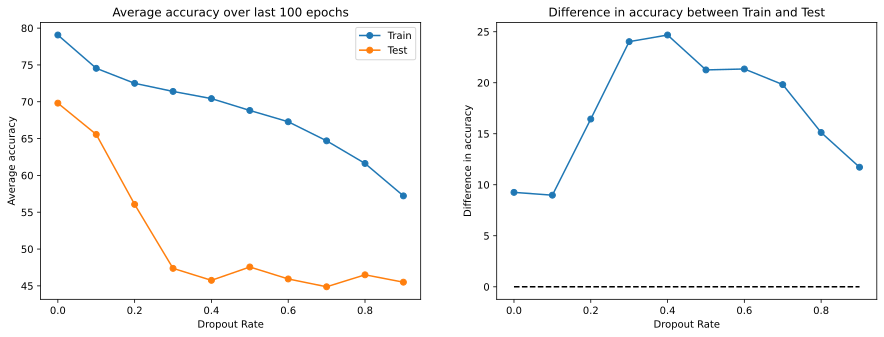

In [71]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(dropout_rate,results,'o-')
ax[0].set_xlabel('Dropout Rate')
ax[0].set_ylabel('Average accuracy')
ax[0].set_title('Average accuracy over last 100 epochs')
ax[0].legend(['Train','Test'])

ax[1].plot(dropout_rate,-np.diff(results,axis=1),'o-')
ax[1].set_xlabel('Dropout Rate')
ax[1].set_ylabel('Difference in accuracy')
ax[1].set_title('Difference in accuracy between Train and Test')
ax[1].plot([0,.9],[0,0],'k--')
plt.show()

# Mini batches

In [17]:
train_data.tensors[0].shape

torch.Size([320, 2])

In [18]:
batch_sizes = [4,8,16,32,64,128]

Epoch 0 training accuracy 54.0625
Epoch 1 training accuracy 54.6875
Epoch 2 training accuracy 59.375
Epoch 3 training accuracy 60.3125
Epoch 4 training accuracy 60.0
Epoch 5 training accuracy 62.5
Epoch 6 training accuracy 58.75
Epoch 7 training accuracy 59.6875
Epoch 8 training accuracy 61.5625
Epoch 9 training accuracy 65.625
Epoch 10 training accuracy 61.5625
Epoch 11 training accuracy 62.5
Epoch 12 training accuracy 64.375
Epoch 13 training accuracy 62.8125
Epoch 14 training accuracy 61.875
Epoch 15 training accuracy 62.5
Epoch 16 training accuracy 66.875
Epoch 17 training accuracy 65.625
Epoch 18 training accuracy 63.4375
Epoch 19 training accuracy 63.4375
Epoch 20 training accuracy 64.0625
Epoch 21 training accuracy 67.1875
Epoch 22 training accuracy 62.8125
Epoch 23 training accuracy 65.9375
Epoch 24 training accuracy 65.3125
Epoch 25 training accuracy 68.125
Epoch 26 training accuracy 65.625
Epoch 27 training accuracy 66.875
Epoch 28 training accuracy 65.3125
Epoch 29 training 

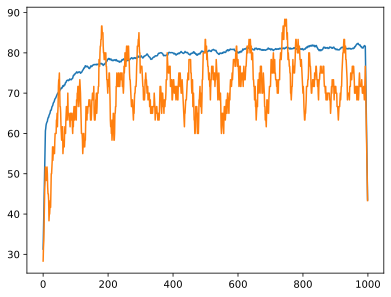

Epoch 0 training accuracy 56.875
Epoch 1 training accuracy 59.375
Epoch 2 training accuracy 59.6875
Epoch 3 training accuracy 60.9375
Epoch 4 training accuracy 60.3125
Epoch 5 training accuracy 63.75
Epoch 6 training accuracy 61.25
Epoch 7 training accuracy 61.5625
Epoch 8 training accuracy 65.3125
Epoch 9 training accuracy 64.6875
Epoch 10 training accuracy 62.1875
Epoch 11 training accuracy 62.1875
Epoch 12 training accuracy 63.75
Epoch 13 training accuracy 64.0625
Epoch 14 training accuracy 64.0625
Epoch 15 training accuracy 62.8125
Epoch 16 training accuracy 62.1875
Epoch 17 training accuracy 65.3125
Epoch 18 training accuracy 64.6875
Epoch 19 training accuracy 65.3125
Epoch 20 training accuracy 67.5
Epoch 21 training accuracy 65.0
Epoch 22 training accuracy 65.3125
Epoch 23 training accuracy 65.0
Epoch 24 training accuracy 65.0
Epoch 25 training accuracy 64.375
Epoch 26 training accuracy 67.5
Epoch 27 training accuracy 65.3125
Epoch 28 training accuracy 65.3125
Epoch 29 training a

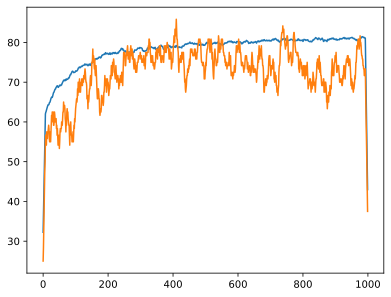

Epoch 0 training accuracy 62.5
Epoch 1 training accuracy 57.5
Epoch 2 training accuracy 61.875
Epoch 3 training accuracy 60.625
Epoch 4 training accuracy 64.0625
Epoch 5 training accuracy 60.3125
Epoch 6 training accuracy 61.875
Epoch 7 training accuracy 62.1875
Epoch 8 training accuracy 62.5
Epoch 9 training accuracy 65.0
Epoch 10 training accuracy 62.8125
Epoch 11 training accuracy 65.625
Epoch 12 training accuracy 61.5625
Epoch 13 training accuracy 66.875
Epoch 14 training accuracy 60.625
Epoch 15 training accuracy 65.0
Epoch 16 training accuracy 67.1875
Epoch 17 training accuracy 62.1875
Epoch 18 training accuracy 62.5
Epoch 19 training accuracy 63.4375
Epoch 20 training accuracy 64.375
Epoch 21 training accuracy 64.0625
Epoch 22 training accuracy 60.9375
Epoch 23 training accuracy 65.9375
Epoch 24 training accuracy 63.4375
Epoch 25 training accuracy 62.8125
Epoch 26 training accuracy 63.4375
Epoch 27 training accuracy 66.25
Epoch 28 training accuracy 65.625
Epoch 29 training accur

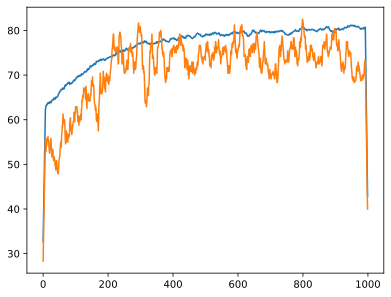

Epoch 0 training accuracy 59.0625
Epoch 1 training accuracy 61.25
Epoch 2 training accuracy 58.75
Epoch 3 training accuracy 62.1875
Epoch 4 training accuracy 61.25
Epoch 5 training accuracy 62.8125
Epoch 6 training accuracy 60.3125
Epoch 7 training accuracy 62.1875
Epoch 8 training accuracy 62.8125
Epoch 9 training accuracy 62.5
Epoch 10 training accuracy 64.6875
Epoch 11 training accuracy 62.1875
Epoch 12 training accuracy 60.625
Epoch 13 training accuracy 61.875
Epoch 14 training accuracy 61.875
Epoch 15 training accuracy 63.125
Epoch 16 training accuracy 65.625
Epoch 17 training accuracy 60.0
Epoch 18 training accuracy 62.1875
Epoch 19 training accuracy 62.1875
Epoch 20 training accuracy 63.4375
Epoch 21 training accuracy 64.0625
Epoch 22 training accuracy 63.75
Epoch 23 training accuracy 63.125
Epoch 24 training accuracy 64.0625
Epoch 25 training accuracy 60.9375
Epoch 26 training accuracy 64.6875
Epoch 27 training accuracy 62.5
Epoch 28 training accuracy 66.5625
Epoch 29 training 

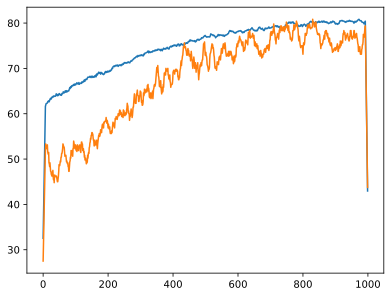

Epoch 0 training accuracy 51.5625
Epoch 1 training accuracy 53.4375
Epoch 2 training accuracy 53.75
Epoch 3 training accuracy 55.625
Epoch 4 training accuracy 56.25
Epoch 5 training accuracy 57.1875
Epoch 6 training accuracy 57.5
Epoch 7 training accuracy 56.875
Epoch 8 training accuracy 59.6875
Epoch 9 training accuracy 59.6875
Epoch 10 training accuracy 58.75
Epoch 11 training accuracy 58.125
Epoch 12 training accuracy 60.0
Epoch 13 training accuracy 61.25
Epoch 14 training accuracy 59.375
Epoch 15 training accuracy 62.5
Epoch 16 training accuracy 59.0625
Epoch 17 training accuracy 60.0
Epoch 18 training accuracy 62.8125
Epoch 19 training accuracy 62.8125
Epoch 20 training accuracy 60.3125
Epoch 21 training accuracy 62.8125
Epoch 22 training accuracy 59.0625
Epoch 23 training accuracy 63.125
Epoch 24 training accuracy 61.875
Epoch 25 training accuracy 63.125
Epoch 26 training accuracy 61.875
Epoch 27 training accuracy 62.1875
Epoch 28 training accuracy 62.8125
Epoch 29 training accur

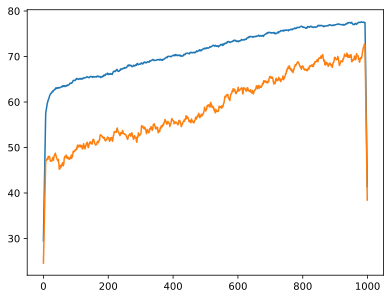

Epoch 0 training accuracy 55.729166666666664
Epoch 1 training accuracy 58.854166666666664
Epoch 2 training accuracy 66.14583333333333
Epoch 3 training accuracy 69.53125
Epoch 4 training accuracy 66.66666666666667
Epoch 5 training accuracy 66.40625
Epoch 6 training accuracy 65.10416666666667
Epoch 7 training accuracy 62.239583333333336
Epoch 8 training accuracy 62.5
Epoch 9 training accuracy 64.32291666666667
Epoch 10 training accuracy 63.28125
Epoch 11 training accuracy 63.020833333333336
Epoch 12 training accuracy 64.58333333333333
Epoch 13 training accuracy 64.32291666666667
Epoch 14 training accuracy 64.84375
Epoch 15 training accuracy 62.239583333333336
Epoch 16 training accuracy 63.020833333333336
Epoch 17 training accuracy 64.58333333333333
Epoch 18 training accuracy 64.0625
Epoch 19 training accuracy 62.239583333333336
Epoch 20 training accuracy 65.625
Epoch 21 training accuracy 62.5
Epoch 22 training accuracy 65.10416666666667
Epoch 23 training accuracy 64.32291666666667
Epoch 

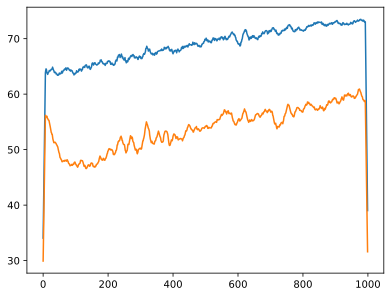

In [22]:
for batch_size in batch_sizes:
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
    model,loss_function,optimizer = createNewModel()
    trainAcc, testAcc = trainTheModel(model,loss_function,optimizer,train_loader,test_loader)  
    plt.plot(smooth(trainAcc),label=f'Train {batch_size}')
    plt.plot(smooth(testAcc),label=f'Test {batch_size}')
    plt.show()
    